Import some usefull libraries

In [2]:
import matplotlib
%matplotlib inline
from pprint import pprint
import pickle
import glob
import os
import datetime
import sys
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf

import cv2
import os

import numpy as np

In [4]:
from keras.models import Model as KerasModel
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, Concatenate, LeakyReLU
from tensorflow.keras.optimizers import Adam

Checking if everything is working as inteneded

In [5]:
print(sys.version_info)
for module in (tf,matplotlib, np, pd, scipy, keras, tf, cv2):
    print(module.__name__, module.__version__)

sys.version_info(major=3, minor=10, micro=4, releaselevel='final', serial=0)
tensorflow 2.9.1
matplotlib 3.5.2
numpy 1.23.1
pandas 1.4.3
scipy 1.8.1
keras 2.9.0
tensorflow 2.9.1
cv2 4.6.0


Setting the base path for the dataset

In [6]:
BASE_PATH = './dataset/'

In [7]:
tf.test.gpu_device_name()

'/device:GPU:0'

### Description of Subsets
|  Subset   | Method  |
|  ----  | ----  |
| real_fulls.zip |   original Celeb-DF real data |  
|fake_baseline.zip	|				 original Celeb-DF fake data|  
|DFGC_SYSU_852924.zip    |		 Adversarial Attacks with some post processing|  
|jerryHUST_853638.zip  		|	 FaceShifter + Adversarial Attacks; A self-trained faceswap model with some post processing|  
|miaotao_853000.zip  		|	 FaceShifter|  
|seanseattle_853068.zip  	|	 FaceController + Adversarial Attacks    |  
|yZzzzzz_849853.zip			|	 MegaFS on 256 resolution|  
|DFischerHDA_852673.zip  	|	 FaceMorpher + dlib landmarks +|  
|joshhu_853266.zip  		|		 Adversarial Attacks   |  
|nbhh_853436.zip     		|	 FaceShifter + Adversarial Attacks|  
|smartz_849705.zip       	|	 A face-anonymization algorithm generated data|  
|yangquanwei_852303.zip  	|	 Swap facial regions based on key points of the face|  
|zhaobh_852336.zip			|	 Using an adversarial model to generate noise to add on warp-based face swap results|  
|ctmiu_853213.zip   		|		 FaceShifter + Adversarial Attacks  |  
|lowtec_853184.zip   		|	 FacceShifter with some post processing      |  
|wany_853175.zip   			|	 face shifter      |  
|yuejiang_852934.zip    	|		 crop and paste |  
|zz110_853170.zip			|	 unkown|  
### Metadata
*bbox&landmarks.json* includes the pre-computed bounding-box, 5-landmarks, and 68 landmarks information.
Bounding-box and 5-landmarks are extracted using MTCNN.
The real images metadata are extracted for the *real_fulls* subset. The fake subsets (approximately) share the same 
metadata, which is extracted based on *fake_baseline*.

For now lets look at real_fulls and fake_baseline subsets.

In [12]:
directory = os.path.join('./dataset')
img_height = 32
img_width = 32
batch_size = 32
nb_epochs = 100

print(directory)

train_datagen = ImageDataGenerator(rescale=1./32,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
    directory,
    follow_links=True,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    directory, # same directory as training data
    follow_links=True,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation') # set as validation data


./dataset
Found 1586 images belonging to 2 classes.
Found 396 images belonging to 2 classes.


Creating the model  

In [13]:
learning_rate = 0.001

x = Input(shape = (img_width, img_height, 3))

x1 = Conv2D(8, (3, 3), padding='same', activation = 'relu')(x)
x1 = BatchNormalization()(x1)
x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)

x2 = Conv2D(8, (5, 5), padding='same', activation = 'relu')(x1)
x2 = BatchNormalization()(x2)
x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)

x3 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x2)
x3 = BatchNormalization()(x3)
x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)

x4 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x3)
x4 = BatchNormalization()(x4)
x4 = MaxPooling2D(pool_size=(4, 4), padding='same')(x4)

y = Flatten()(x4)
y = Dropout(0.5)(y)
y = Dense(16)(y)
y = LeakyReLU(alpha=0.1)(y)
y = Dropout(0.5)(y)
y = Dense(1, activation = 'sigmoid')(y)

model =  KerasModel(inputs = x, outputs = y)

optimizer = Adam(learning_rate = learning_rate)
model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['accuracy'])

In [14]:
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = nb_epochs)

Epoch 1/100
49/49 [==============================] - 23s 296ms/step - loss: 0.3517 - accuracy: 0.5135 - val_loss: 0.2499 - val_accuracy: 0.4870
Epoch 2/100
49/49 [==============================] - 4s 79ms/step - loss: 0.3076 - accuracy: 0.5457 - val_loss: 0.2548 - val_accuracy: 0.4766
Epoch 3/100
49/49 [==============================] - 4s 80ms/step - loss: 0.2600 - accuracy: 0.5985 - val_loss: 0.2904 - val_accuracy: 0.5052
Epoch 4/100
49/49 [==============================] - 4s 76ms/step - loss: 0.2575 - accuracy: 0.5901 - val_loss: 0.2613 - val_accuracy: 0.4583
Epoch 5/100
49/49 [==============================] - 4s 79ms/step - loss: 0.2391 - accuracy: 0.6184 - val_loss: 0.2776 - val_accuracy: 0.4036
Epoch 6/100
49/49 [==============================] - 4s 83ms/step - loss: 0.2355 - accuracy: 0.6403 - val_loss: 0.2765 - val_accuracy: 0.4688
Epoch 7/100
49/49 [==============================] - 4s 82ms/step - loss: 0.2375 - accuracy: 0.6184 - val_loss: 0.2720 - val_accuracy: 0.4688
Epoc

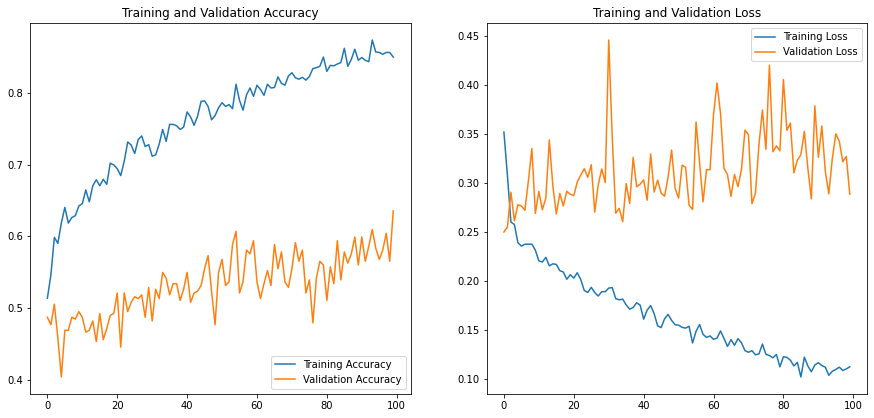

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(nb_epochs)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()